In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")
OUTPUT_EXP21_DIR = DIR + '/output/EXP021/'
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
!pip install catboost
#!pip install category_encoders
#!pip install feature_engine
#!pip install featuretools
#!pip install woodwork

import lightgbm as lgb
import xgboost as xgb
from catboost import *
import catboost as ctb
from catboost import Pool
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score

from sklearn import preprocessing
#from category_encoders.target_encoder import TargetEncoder
#from feature_engine.encoding import WoEEncoder
#import featuretools as ft
#from woodwork.logical_types import Categorical

In [5]:
v3_pred_df = pd.read_pickle(OUTPUT_EXP21_DIR+'oof_df.pkl')
v3_pred_df.rename(columns={"pred":"v3_pred"},inplace=True)
v3_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_microsoft-deberta-v3-base_seed42_ver21.csv"), header=None)[1]

oof_df = pd.read_csv(os.path.join(OOF_DIR, f'oof_catboost_ver17.csv'))
oof_df.rename(columns={"pred":"oof17_pred"},inplace=True)
oof17_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_catboost_ver17.csv"), header=None)[1]

train = pd.read_csv(os.path.join(INPUT_DIR,"train.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
card = pd.read_csv(os.path.join(INPUT_DIR, "card.csv"))
user = pd.read_csv(os.path.join(INPUT_DIR, "user.csv"))
sub = pd.read_csv(os.path.join(INPUT_DIR, "sample_submit.csv"), header=None)

In [6]:
numerical_features = ["amount", "cards_issued", "credit_limit", "current_age", "retirement_age", "birth_year", "latitude", "longitude",
                      "per_capita_income_zipcode", "yearly_income_person", "total_debt", "fico_score", "num_credit_cards", "income_rate"]
categorical_features = ["user_id", "card_id", "errors?", "merchant_id", "merchant_city", "merchant_state", "mcc", "use_chip",
                        "card_brand", "card_type", "has_chip", "gender", "city", "state",
                        "birth_month",
                        ]
target = "is_fraud?"

In [7]:
train = train.merge(oof_df[["index", "oof17_pred", "fold"]], how="left", on="index").merge(v3_pred_df[["index", "v3_pred"]], how="left", on="index")
test["oof17_pred"] = oof17_test
test["v3_pred"] = v3_test

In [8]:
concat_data = pd.concat([train,test],axis=0)
concat_data = concat_data.merge(card, how="left", on=["user_id", "card_id"]).merge(user, how="left", on="user_id")

concat_data = concat_data.fillna("NAN")

city_c = concat_data["merchant_city"].value_counts(normalize=True).to_dict()
state_c = concat_data["merchant_state"].value_counts(normalize=True).to_dict()

concat_data["city_c"] = concat_data["merchant_city"].map(lambda x: city_c[x]).values
concat_data["state_c"] = concat_data["merchant_state"].map(lambda x: state_c[x]).values

concat_data.loc[concat_data["city_c"]<0.0005, "merchant_city"] = "Rare_city"
concat_data.loc[concat_data["state_c"]<0.0005, "merchant_state"] = "Rare_state"


for col in categorical_features:
  oof17_agg = concat_data.groupby(col)["oof17_pred"].agg(["mean", "std", "max", "min"])
  oof17_agg = oof17_agg.add_prefix(f'agg17_{col}_')
  oof17_agg = oof17_agg.reset_index()

  oofv3_agg = concat_data.groupby(col)["v3_pred"].agg(["mean", "std", "max", "min"])
  oofv3_agg = oofv3_agg.add_prefix(f'aggv3_{col}_')
  oofv3_agg = oofv3_agg.reset_index()

  concat_data = concat_data.merge(oof17_agg, how="left", on=col).merge(oofv3_agg, how="left", on=col)

In [9]:
train_df = concat_data.iloc[:train.shape[0],:]
train_df = train_df.reset_index(drop=True)
test_df = concat_data.iloc[train.shape[0]:,:]
test_df = test_df.reset_index(drop=True)

In [10]:
# amount_user_mean = train_df.groupby("user_id")["amount"].mean().to_dict()
# train_df["amount_mean"] = train_df["user_id"].map(lambda x: amount_user_mean[x]).values
# test_df["amount_mean"] = test_df["user_id"].map(lambda x: amount_user_mean[x]).values
# train_df["diff_amount"] = train_df["amount"] - train_df["amount_mean"]
# test_df["diff_amount"] = test_df["amount"] - test_df["amount_mean"]

In [11]:
"""
train_df["neg_is_franud?"] = pd.Series(np.where(train_df[target]==1.0, 0.0, 1.0))
total_pos = train_df[target].sum()
total_neg = train_df["neg_is_franud?"].sum()

for col in categorical_features:
  print(col)
  if col=="merchant_id":
    continue
  pos = train_df.groupby(col)[target].sum() / total_pos
  neg = train_df.groupby(col)["neg_is_franud?"].sum() / total_neg
  woe = pos/neg
  train_df[f"{col}_woe"] = np.log(train_df[col].map(woe).astype(float))
  test_df[f"{col}_woe"] = np.log(test_df[col].map(woe).astype(float))
"""

'\ntrain_df["neg_is_franud?"] = pd.Series(np.where(train_df[target]==1.0, 0.0, 1.0))\ntotal_pos = train_df[target].sum()\ntotal_neg = train_df["neg_is_franud?"].sum()\n\nfor col in categorical_features:\n  print(col)\n  if col=="merchant_id":\n    continue\n  pos = train_df.groupby(col)[target].sum() / total_pos\n  neg = train_df.groupby(col)["neg_is_franud?"].sum() / total_neg\n  woe = pos/neg\n  train_df[f"{col}_woe"] = np.log(train_df[col].map(woe).astype(float))\n  test_df[f"{col}_woe"] = np.log(test_df[col].map(woe).astype(float))\n'

In [12]:
train_df[target] = train_df[target].astype(float)
corr_list = [target] + [f"agg17_{col}_mean" for col in categorical_features] + [f"aggv3_{col}_mean" for col in categorical_features]
train_df[corr_list].corr()

,is_fraud?,agg17_user_id_mean,agg17_card_id_mean,agg17_errors?_mean,agg17_merchant_id_mean,agg17_merchant_city_mean,agg17_merchant_state_mean,agg17_mcc_mean,agg17_use_chip_mean,agg17_card_brand_mean,...,aggv3_merchant_state_mean,aggv3_mcc_mean,aggv3_use_chip_mean,aggv3_card_brand_mean,aggv3_card_type_mean,aggv3_has_chip_mean,aggv3_gender_mean,aggv3_city_mean,aggv3_state_mean,aggv3_birth_month_mean
is_fraud?,1.000000,0.103949,0.023271,0.040477,0.592848,0.328891,0.310254,0.231364,0.227548,0.030013,...,0.310225,0.206636,0.227553,0.030088,0.024531,0.023347,0.017183,0.096445,0.043183,0.046331
agg17_user_id_mean,0.103949,1.000000,0.144460,-0.034375,0.103190,0.068805,0.027086,-0.007549,0.010817,0.119854,...,0.027093,-0.013748,0.010866,0.124472,0.088735,0.047695,0.161829,0.921110,0.407494,0.445684
agg17_card_id_mean,0.023271,0.144460,1.000000,0.014523,0.023498,0.011178,-0.000877,0.011211,-0.009312,0.014159,...,0.000544,0.002499,-0.009251,0.019656,0.044411,-0.085840,0.030886,0.169124,0.060718,0.134060
agg17_errors?_mean,0.040477,-0.034375,0.014523,1.000000,0.018620,-0.071414,-0.064294,-0.024691,-0.093910,0.007289,...,-0.064114,-0.054271,-0.093973,0.007754,0.017159,-0.015513,-0.019905,-0.023572,-0.013222,-0.006620
agg17_merchant_id_mean,0.592848,0.103190,0.023498,0.018620,1.000000,0.584192,0.551238,0.406408,0.399685,0.026990,...,0.551100,0.363320,0.399684,0.027654,0.023316,0.025960,0.016651,0.099425,0.045432,0.041411
agg17_merchant_city_mean,0.328891,0.068805,0.011178,-0.071414,0.584192,1.000000,0.933593,0.357284,0.684133,0.005200,...,0.933555,0.511752,0.684073,0.005699,0.007569,0.033675,0.014818,0.068970,0.041290,-0.004933
agg17_merchant_state_mean,0.310254,0.027086,-0.000877,-0.064294,0.551238,0.933593,1.000000,0.311129,0.723882,-0.000101,...,0.999704,0.482709,0.723811,-0.000064,-0.004509,0.031169,0.029137,0.024042,0.038192,-0.021224
agg17_mcc_mean,0.231364,-0.007549,0.011211,-0.024691,0.406408,0.357284,0.311129,1.000000,0.289434,-0.004381,...,0.310857,0.894506,0.289276,-0.002950,-0.001342,0.015971,-0.004148,-0.008196,-0.016512,-0.000626
agg17_use_chip_mean,0.227548,0.010817,-0.009312,-0.093910,0.399685,0.684133,0.723882,0.289434,1.000000,0.005969,...,0.722142,0.522053,0.999994,0.007637,0.001936,0.041365,0.022549,0.005538,-0.005403,-0.022459
agg17_card_brand_mean,0.030013,0.119854,0.014159,0.007289,0.026990,0.005200,-0.000101,-0.004381,0.005969,1.000000,...,-0.000373,-0.007280,0.006051,0.998170,0.112795,0.053025,0.034769,0.084793,0.029724,0.039105


In [13]:
class CFG:
  debug=False
  ver=29
  model="catboost"
  n_folds=5
  trn_fold=[0, 1, 2, 3, 4]
  seed=42
  target= target
  boosting_type="gbdt"
  early_stopping_round=50
  verbose=200

In [14]:
if CFG.debug:
    display(train_df.groupby('fold').size())
    train_df = train_df.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train_df.groupby('fold').size())

In [15]:
params = {
        "n_estimators":8000,
        "learning_rate":0.05,
        'depth': 5,
        "random_state":CFG.seed,
        'colsample_bylevel': 0.50,
        'subsample': 0.80,
        'l2_leaf_reg': 3,
    }

features = [f"agg17_{col}_mean" for col in categorical_features] + [f"aggv3_{col}_mean" for col in categorical_features] + [f"agg17_{col}_std" for col in categorical_features] + [f"aggv3_{col}_std" for col in categorical_features] \
+ [f"agg17_{col}_max" for col in categorical_features] + [f"aggv3_{col}_max" for col in categorical_features] + [f"agg17_{col}_min" for col in categorical_features] + [f"aggv3_{col}_min" for col in categorical_features]
oof_df = pd.DataFrame()
test_preds = np.zeros(len(test_df))

for fold in range(CFG.n_folds):
  if fold in CFG.trn_fold:
    print("="*15,f" FOLD : {fold} ","="*15)
    train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)

    train_X = train_folds[features]
    valid_X = valid_folds[features]
    test_X = test_df[features]
    train_labels = train_folds[CFG.target].values
    valid_labels = valid_folds[CFG.target].values

    train_pool = Pool(train_X,
                     label=train_labels
                      )
    valid_pool = Pool(valid_X,
                    label=valid_labels
                      )

    model = ctb.CatBoostClassifier(**params)
    model.fit(train_pool,
              eval_set=[valid_pool],
              early_stopping_rounds=CFG.early_stopping_round,
              verbose=CFG.verbose,
              use_best_model=True)

    valid_folds["pred"] = model.predict_proba(valid_pool)[:, 1]
    test_preds += model.predict_proba(Pool(test_X))[:, 1]
    oof_df = pd.concat([oof_df, valid_folds])

    validy_pred = np.where(valid_folds["pred"]>0.5, 1, 0)
    scoref1 =  f1_score(valid_labels, validy_pred)
    print(f"F1 Score : {scoref1}")
    del model, train_folds, valid_folds, train_X, valid_X, test_X, train_pool, valid_pool, validy_pred

===============  FOLD : 0  ===============
0:	learn: 0.6193599	test: 0.6192918	best: 0.6192918 (0)	total: 216ms	remaining: 28m 48s
200:	learn: 0.1438165	test: 0.1442728	best: 0.1442728 (200)	total: 39.5s	remaining: 25m 33s
400:	learn: 0.1386957	test: 0.1403002	best: 0.1403002 (400)	total: 1m 20s	remaining: 25m 23s
600:	learn: 0.1352441	test: 0.1379087	best: 0.1379087 (600)	total: 2m 13s	remaining: 27m 26s
800:	learn: 0.1325710	test: 0.1360897	best: 0.1360897 (800)	total: 2m 52s	remaining: 25m 53s
1000:	learn: 0.1303508	test: 0.1346408	best: 0.1346408 (1000)	total: 3m 32s	remaining: 24m 42s
1200:	learn: 0.1286293	test: 0.1337008	best: 0.1337008 (1200)	total: 4m 9s	remaining: 23m 32s
1400:	learn: 0.1271694	test: 0.1330215	best: 0.1330215 (1400)	total: 4m 48s	remaining: 22m 40s
1600:	learn: 0.1258578	test: 0.1324761	best: 0.1324761 (1600)	total: 5m 27s	remaining: 21m 49s
1800:	learn: 0.1246912	test: 0.1320272	best: 0.1320242 (1792)	total: 6m 6s	remaining: 21m 1s
2000:	learn: 0.1236350	tes

In [16]:
f1score =  f1_score(oof_df[CFG.target], np.where(oof_df["pred"]>0.5,1,0))
print(f'CV F1 Score: {f1score}')

CV F1 Score: 0.6303434503287552


In [17]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.15, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(oof_df[CFG.target], (oof_df["pred"]>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(oof_df[CFG.target], (oof_df["pred"]>best_thresh).astype(int))))

F1 score at threshold 0.15 is 0.600673139158576
F1 score at threshold 0.16 is 0.6086020362051091
F1 score at threshold 0.17 is 0.614687512756664
F1 score at threshold 0.18 is 0.6206906138790036
F1 score at threshold 0.19 is 0.6264516952397158
F1 score at threshold 0.2 is 0.6302841302841302
F1 score at threshold 0.21 is 0.6333475054611561
F1 score at threshold 0.22 is 0.6357110945644081
F1 score at threshold 0.23 is 0.6382009592470815
F1 score at threshold 0.24 is 0.6415411665774788
F1 score at threshold 0.25 is 0.6442249546462406
F1 score at threshold 0.26 is 0.6466385036983527
F1 score at threshold 0.27 is 0.6487507539921902
F1 score at threshold 0.28 is 0.6491365902932547
F1 score at threshold 0.29 is 0.6499360044067852
F1 score at threshold 0.3 is 0.6503865303983227
F1 score at threshold 0.31 is 0.650165343915344
F1 score at threshold 0.32 is 0.6498807757082591
F1 score at threshold 0.33 is 0.649786475671677
F1 score at threshold 0.34 is 0.6498659335437668
F1 score at threshold 0.35

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0


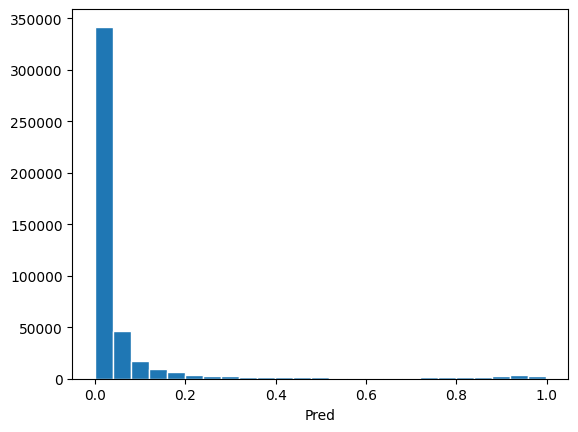

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


0    429851
1     28107
Name: 1, dtype: int64


In [18]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = test_preds / CFG.n_folds
submit[1] = (pred>best_thresh).astype(int)

submit.to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
display(submit.head())

plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit)
print(submit[1].value_counts())

In [19]:
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')

if not os.path.exists(OOF_DIR):
    os.makedirs(OOF_DIR)

oof_df.to_csv(os.path.join(OOF_DIR, f'oof_{CFG.model}_ver{CFG.ver}.csv'))

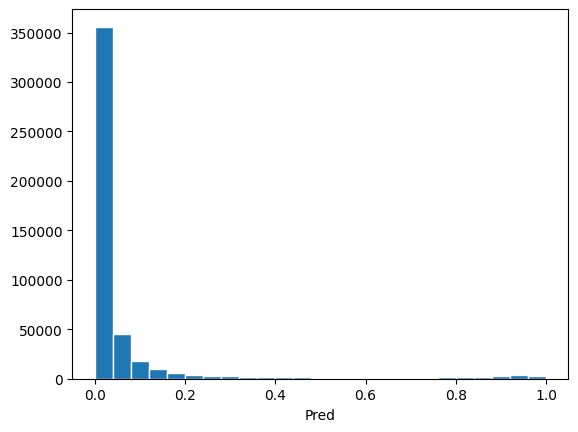

In [20]:
plt.hist(oof_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [21]:
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')

if not os.path.exists(SUB_NUM_DIR):
    os.makedirs(SUB_NUM_DIR)

sub_df = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = test_preds / CFG.n_folds
sub_df[1] = pred

sub_df.to_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
display(sub_df.head())

,0,1
0,471283,0.019969
1,471284,0.029460
2,471285,0.098322
3,471286,0.319436
4,471287,0.008900
